In [1]:
# import libraries 

import pandas as pd 
import numpy as np

from bs4 import BeautifulSoup
import requests
import time
import datetime

import smtplib

import matplotlib.pyplot as plt 
import japanize_matplotlib
import seaborn as sns

import geocoder

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)

# Get Data from tabelog (Japanese Yelp)with Webscraping(BeautifulSoup)

In [2]:
# Connect to Website and pull in data
def get_current_page_info(page_idx):

    URL = f'https://tabelog.com/keywords/%E3%82%B9%E3%83%9A%E3%82%B7%E3%83%A3%E3%83%AA%E3%83%86%E3%82%A3%E3%82%B3%E3%83%BC%E3%83%92%E3%83%BC/tokyo/kwdLst/CC03/{page_idx}/?srchTg=2'
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.108 Safari/537.36", "Accept-Encoding":"gzip, deflate", "Accept":"text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8", "DNT":"1","Connection":"close", "Upgrade-Insecure-Requests":"1"}

    page = requests.get(URL, headers=headers, verify=False)

    soup = BeautifulSoup(page.content, "html.parser")
    soup = BeautifulSoup(soup.prettify(), "html.parser")

    shop_name_list = soup.select("[class='list-rst__rst-name-target cpy-rst-name']")
    area_genre_list = soup.select("[class='list-rst__area-genre cpy-area-genre']")
    rating_list = soup.select("[class='c-rating__val c-rating__val--strong list-rst__rating-val']")
    n_comments_list = soup.select("[class='list-rst__rvw-count-target']")
    n_saved_list = soup.select("[class='list-rst__save-count-num u-text-num']")


    cafe_dic_list = []
    for shop_name, area_genre, rating, n_comments, n_saved  in zip(shop_name_list, area_genre_list, rating_list, n_comments_list, n_saved_list):        
        
        shop = shop_name.get_text()
        area = area_genre.get_text().split('/')[0].strip()
        
        try:
            station = area.split(' ')[0]
            distance = int(area.split(' ')[-1].replace('m', ''))
        except:
            station = area
            distance = np.nan
            
        genre = area_genre.get_text().split('/')[-1].strip()
        rate = float(rating.get_text())
        n_comm = n_comments.get_text() 
        n_save = n_saved.get_text()

        temp_dic = {'name': shop,
                    'station': station, 
                    'distance_m': distance,
                    'genre': genre, 
                    'rate': rate, 
                    'n_comments': n_comm.replace('件', '').strip(), 
                    'n_saved': n_save
                    }

        cafe_dic_list.append(temp_dic)


    sub_cafe_df = pd.DataFrame(cafe_dic_list)
    sub_cafe_df = sub_cafe_df.replace(r'\n',' ', regex=True) 
    
    sub_cafe_df['n_comments'] = sub_cafe_df['n_comments'].astype(int)
    sub_cafe_df['n_saved'] = sub_cafe_df['n_saved'].astype(int)
    
    return sub_cafe_df

def get_coffeeshops_data():
    page_indices = range(1, 11)
    
    cafe_df = pd.concat([get_current_page_info(idx) for idx in page_indices])
    cafe_df = cafe_df.sort_values(by=['rate'], ascending=False).reset_index(drop=True)
    
    return cafe_df


full_cafe_df = get_coffeeshops_data()
full_cafe_df.head()
         


,name,station,distance_m,genre,rate,n_comments,n_saved
0,カフェ・ド・ランブル,新橋駅,409.0,喫茶店、 コーヒー専門店,3.75,687,32070
1,タイズ,本郷三丁目駅,368.0,喫茶店、 コーヒー専門店 ...,3.75,435,25801
2,自家焙煎珈琲みじんこ,湯島駅,440.0,カフェ、 コーヒー専門店 ...,3.74,840,50880
3,茶亭 羽當,渋谷駅,268.0,喫茶店、 コーヒー専門店 ...,3.74,1024,55142
4,十一房珈琲店,銀座一丁目駅,141.0,喫茶店、 コーヒー専門店 ...,3.73,574,20339


# See popular coffee shops in Tokyo

### By coffee shop

<AxesSubplot:xlabel='rate', ylabel='name'>

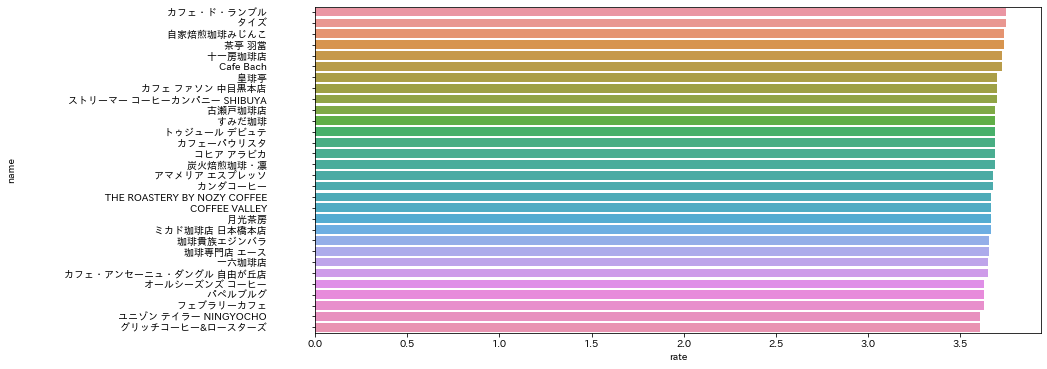

In [3]:
n_top = 30
plt.figure(figsize=(13, 6))
sns.barplot(x = 'rate', y = 'name', data = full_cafe_df.head(n_top))

### By Station

<AxesSubplot:xlabel='station'>

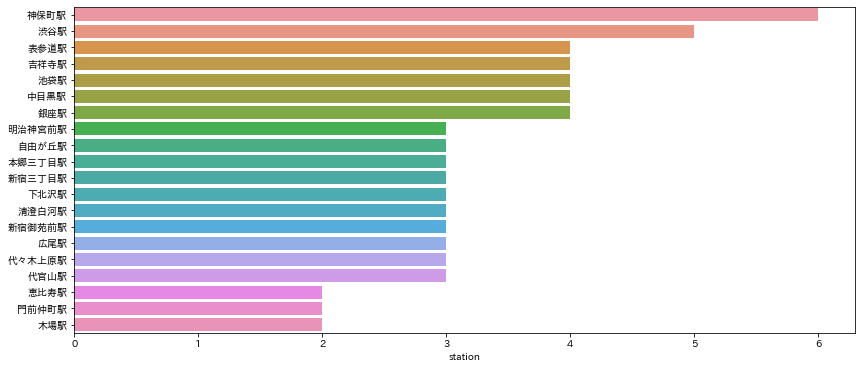

In [4]:
station_counts = full_cafe_df['station'].value_counts().to_frame().head(20)
plt.figure(figsize=(14, 6))
sns.barplot(x = station_counts.station, y = station_counts.index, data = station_counts)

Observations<br>
<li>It seems Jimbocho(神保町) has the most number of popular coffee shops in Tokyo followed by　Shibuya(渋谷) and Harajuku（原宿）. Shibuya and Harajuku are next to each other so I would recommend to go there if you have very short time to explore coffee shops in Tokyo. </li>

# Analysis between Kissaten(Traditional Japanese Style Coffee shop) and Modern Coffee shop<br>
When I see column genre and name, it seems coffee shops can be categorized into 2<br>
<li>Kissaten - 喫茶店 --> Traditional Japanese Style Coffee shops</li>
<li>Modern Coffee shop --> Modern Coffee shops which are not fully traditional japanese style and somehow inspired by coffee shops in overseas. Specially Coffee shops are also included in this category.</li>

In [5]:
# Filter only coffeeshops specilized in coffee 'コーヒー専門店'
cafe_df = full_cafe_df[full_cafe_df['genre'].str.contains('コーヒー専門店')]

# Filter Kissaten
kistn_df = cafe_df[cafe_df['genre'].str.contains('喫茶店')]

# Filter Other coffeeshop
mdn_df = cafe_df[~cafe_df['genre'].str.contains('喫茶店')]

### See Ratio between categories

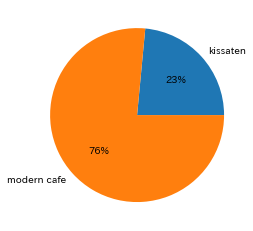

In [6]:
plt.pie([len(kistn_df), len(mdn_df)], labels = ['kissaten', 'modern cafe'], autopct='%.0f%%')
plt.text(0, 0, '').remove()

Observations<br>
<li>Modern Cafe is majority</li>

### See which category is more popular 

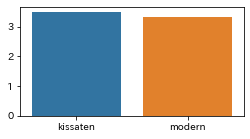

In [7]:
plt.figure(figsize=(4, 2))
sns.barplot(x = ['kissaten', 'modern'], 
            y = [kistn_df['rate'].mean(), mdn_df['rate'].mean()])
plt.text(0, 0, '').remove()

Observations<br>
<li>Looks like 'kissaten' is slightly more popular</li>

### See top coffee shops in each category

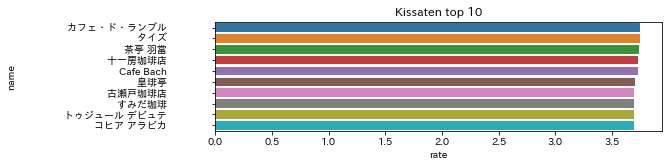

In [8]:
n_top = 10
plt.figure(figsize=(8, 2))
sns.barplot(x = 'rate', y = 'name', data = kistn_df.head(n_top))
plt.title(f'Kissaten top {n_top}')
plt.text(0, 0, '').remove()

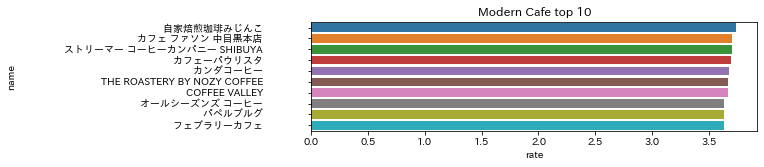

In [9]:
n_top = 10
plt.figure(figsize=(8, 2))
sns.barplot(x = 'rate', y = 'name', data = mdn_df.head(n_top))
plt.title(f'Modern Cafe top {n_top}')
plt.text(0, 0, '').remove()

In [10]:
import geocoder
location = '神保町駅'
ret = geocoder.osm(location, timeout=5.0)
print(ret.latlng)
print(ret.address)

[35.6959719, 139.7583937]
神保町, 靖国通り, 神田神保町一丁目, 神田神保町, 千代田区, 東京都, 101-0051, 日本


In [11]:
station_counts

,station
神保町駅,6
渋谷駅,5
表参道駅,4
吉祥寺駅,4
池袋駅,4
中目黒駅,4
銀座駅,4
明治神宮前駅,3
自由が丘駅,3
本郷三丁目駅,3
